## Parsing for the w09-data.tbl

In [1]:
import numpy as np
import math
import re
import sys

# Ooh look! Parsing for the w08-data.tbl
# This leaves us with
#    N         : number of experiments (columns in the table)
#    G         : number of genes (rows in the table)
#    X[i]      : array of time points, in hrs, for the N experiments
#    S_true[i] : array of sigmas for the experiments
#    Y[i][t]   : GxN: observed tpm for gene i, time point t
#   
datafile = 'w08-data.tbl'
with open(datafile) as f:
    # First header line gives us the time points
    fields = f.readline().split()
    X = []
    for s in fields:
        match = re.search(r'^(\d+)hr', s)
        X.append(int(match.group(1)))
    X = np.array(X)
    N = len(X)

    # Second header line gives us "gene" followed by +=SD's
    fields = f.readline().split()
    S_true = np.zeros(N)
    for i,s in enumerate(fields[1:]):
        match = re.search(r'^\+-(\d+)', s)
        S_true[i] = float(match.group(1))

    # Third header line is just ------ stuff
    f.readline()

    # Remaining lines are data
    genenames = []
    Y = []
    for line in f.readlines():
        fields = line.split()
        genenames.append(fields[0])
        Y.append( np.array( [ float(s) for s in fields[1:]] ))
    G = len(Y)

## Get Morality's estimates from given code

In [2]:


# Moriarty's method: ordinary least squares on:
#    y_t = b + (a cos p) sin t + (a sin p) cos t
#
b_fit_m = np.zeros(G)
a_fit_m = np.zeros(G)
p_fit_m = np.zeros(G)

all_results_moriarty = []
for g in range(G):
    # We have to set up a matrix A the way numpy.linalg.lstsq() wants it.
    #
    A = np.zeros((N, 3))  # observations x coefficients
    for i in range(N):
        A[i][0] = 1.
        A[i][1] = np.sin(2. * math.pi * X[i] / 24)  
        A[i][2] = np.cos(2. * math.pi * X[i] / 24)

    try:
        result_moriarty    = np.linalg.lstsq(A, Y[g], rcond=-1)[0]
    except:
        sys.exit("Linear least square fit failed")

    all_results_moriarty.append(result_moriarty)
    p_fit_m[g]  = np.arctan(result_moriarty[2] / result_moriarty[1])   # in radians at first
    b_fit_m[g]  = result_moriarty[0]
    a_fit_m[g]  = result_moriarty[1] / np.cos(p_fit_m[g])
    p_fit_m[g] = 24 * p_fit_m[g] / (2 * math.pi) 
    
   

    
    
          # now in hours
    if a_fit_m[g] < 0:                               # there's a symmetry in the solution we have to deal with.
        a_fit_m[g]  = -a_fit_m[g]
        p_fit_m[g] += 12
    while p_fit_m[g] < 0:  p_fit_m[g] += 24
    while p_fit_m[g] > 24: p_fit_m[g] -= 24




## 1. Solve by maximum likelihood

### Create my negative log likelihhod (NLL) function

In [3]:
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import norm



def nll(p, D):
    """
    This function takes in a set of parameters and data, then
    computes the negative log likelihood with the defined likelihood function
    """

    p_0, p_1, p_2 = p
    y_pred = p_0 + p_1 * np.sin(2*np.pi*(1/24)*X) + p_2*np.cos(2*np.pi*(1/24)*X)
    ll_terms = norm.logpdf(D-y_pred, loc=0, scale=S_true)
    return -ll_terms.sum()
    
def get_estimated_params(initialized_params):

    estimated_parms = pd.DataFrame(columns=['b', 'a', 'phi'])

    b_fit = np.zeros(G)
    a_fit = np.zeros(G)
    p_fit = np.zeros(G)


    all_my_results = []
    for gene in range(0,G):
    
        my_result = minimize(nll,np.array([1,1,1]),args=(Y[gene]))
        all_my_results.append(my_result.x)
        p_fit  = np.arctan(my_result.x[2] / my_result.x[1])   # in radians at first
        b_fit  = my_result.x[0]
        a_fit  = my_result.x[1] / np.cos(p_fit)
        p_fit = 24 * p_fit / (2 * math.pi)


        if a_fit < 0:                               # there's a symmetry in the solution we have to deal with.
            a_fit = -a_fit
            p_fit += 12
        while p_fit < 0:  p_fit += 24
        while p_fit > 24: p_fit -= 24

        new = {'b':b_fit,'a':a_fit,'phi':p_fit}
        estimated_parms = estimated_parms.append(new,ignore_index=True)
    return estimated_parms, all_my_results



### To avoid running into a local minima in the negative-log-likelihood loss function in the optimization process, I decided to run the model with 100 different sets of randomly intialized parameters and I will choose the set of randomly initialized parameters that minimizes the sum of my negative log-likelihood-loss function over all genes.

In [11]:
# These two lists store all of the randomly initialize parameteres and the sum of negative log likelihood generated
# from all of them

all_set_of_initailized_params = []
all_sum_neg_log_likelihood = []


# Iterating through 100 random initialized parameters
for i in range(0,100):

    intial_params = np.random.randint(1000,size=3, dtype=int)
    all_set_of_initailized_params.append(intial_params)
    estimated_parms, all_my_results = get_estimated_params(intial_params)
    all_log_likelihood_mine = []

    # calculate the sum of negative log likelihood
    for gene in range(0,G):
        all_log_likelihood_mine.append(nll(all_my_results[gene],Y[gene]))
    all_sum_neg_log_likelihood.append(np.sum(np.array(all_log_likelihood_mine)))

# find the set of initailzied parameters that yielded the lowest negative log likelihood
min_index = np.argmin(np.array(all_sum_neg_log_likelihood))
best_initialized_params = all_set_of_initailized_params[min_index]

estimated_parms, all_my_results = get_estimated_params(best_initialized_params)
estimated_parms['b_moriarty'] =  b_fit_m
estimated_parms['a_moriarty'] =  a_fit_m
estimated_parms['phi_moriarty'] =  p_fit_m

estimated_parms['gene_name'] = genenames
estimated_parms


,b,a,phi,b_moriarty,a_moriarty,phi_moriarty,gene_name
0,39.992320,22.415067,0.448693,48.556667,15.665829,0.608887,anise
1,48.840384,31.842562,16.264642,52.704167,33.463583,15.584165,kiwi
2,47.576549,24.231281,21.414571,46.906111,26.081784,21.331005,carrot
3,44.901806,32.333723,20.420184,41.683333,30.167409,20.206698,grape
4,42.756347,22.147729,2.777178,47.539167,22.961804,2.600821,tangerine
5,51.264739,19.099474,6.687286,46.481111,27.435235,8.155203,melon
6,48.018064,27.596012,10.157139,42.090278,18.320487,9.358910,clementine
7,49.725858,18.400943,14.265081,51.880278,14.389623,14.260740,spinach
8,40.852182,30.614596,7.420647,43.125833,35.656417,6.479506,beet
9,45.986015,21.577501,11.465679,45.055000,28.935973,10.851482,huckleberry


### My estimations of a, b, and phi deviate from Moriarty's estimations.

## 2. Compare Solutions

In [30]:
from scipy import special 
all_log_likelihood_mine = []
all_log_likelihood_Moriarty = []
for gene in range(0,G):
    all_log_likelihood_mine.append(-nll(all_my_results[gene],Y[gene]))
print('Total log likelihood calculated by me')
print(np.sum(np.array(all_log_likelihood_mine)))


for gene in range(0,G):
    all_log_likelihood_Moriarty.append(-nll(all_results_moriarty[gene],Y[gene]))
print('Total log likelihood calculated by Moriarty')    
print(np.sum(np.array(all_log_likelihood_Moriarty)))

print("Ratio of Total Likelihood: (mine vs moriarty)")
print(np.exp(np.sum(np.array(all_log_likelihood_mine))) / np.exp(np.sum(np.array(all_log_likelihood_Moriarty))))



Total log likelihood calculated by me
-311.7296427163954
Total log likelihood calculated by Moriarty
-445.6858896941944
Ratio of Total Likelihood: (mine vs moriarty)
1.501270251597154e+58


### I observe that the total log likelihood calculated through maximum likelihood estimation is higher. This is because Moriarty's least squares estimation assumes equal variance, but my maximum likelihood estimation took into account the changing variance that is dependent on the time t. According to my calculation of the total likelihood ratio between the two estimates, my estimates are 1.50 * 10^58 times more likely. Therefore, if Moriarty offers me even odds bet, I will defintley take it.

## 3. Plot the files

In [19]:
import matplotlib.pyplot as plt
Y_me = []
x = range(0,24)

# Calculating the fitted curves for my estimations and moriarity's estimations
for gene in range(0,G):
    Y_me.append(estimated_parms.b.to_numpy()[gene] + estimated_parms.a.to_numpy()[gene] * np.sin(2*np.pi*(1/24)*(x+estimated_parms.phi.to_numpy()[gene])))

Y_moriarity = []

for gene in range(0,G):
    Y_moriarity.append(b_fit_m[gene] + a_fit_m[gene] * np.sin(2*np.pi*(1/24)*(x+p_fit_m[gene])))


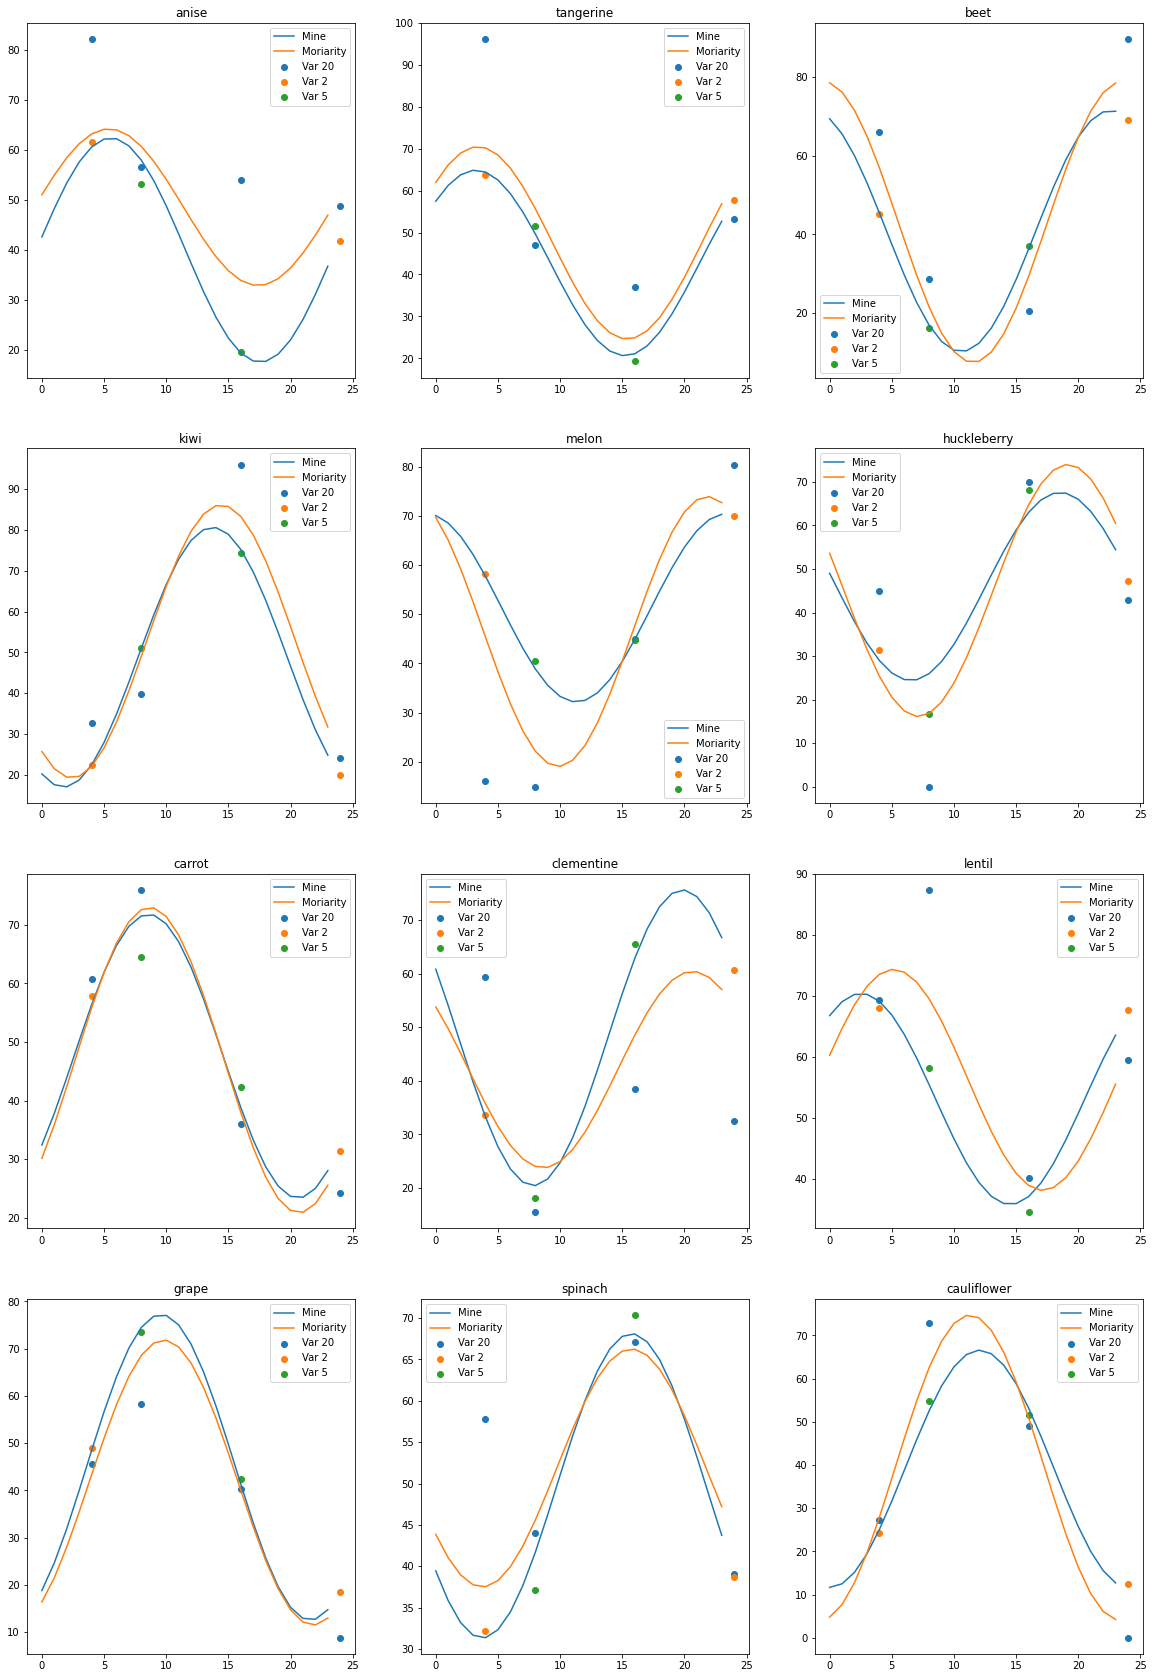

In [35]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

fig, axs = plt.subplots(4,3,figsize=(20,30))


"""
a chunk that starts with a for loop plots the actual values and 
two fits for one gene. The chunk is repeated 12 times
"""

for i in range(0,12):
        
        axs[i%4,i//4].scatter([X[0],X[2],X[5],X[7]],[Y[i][0],Y[i][2],Y[i][5],Y[i][7]],label='Var 20')
        axs[i%4,i//4].scatter([X[1],X[6]],[Y[i][1],Y[i][6]],label='Var 2')
        axs[i%4,i//4].scatter([X[3],X[4]],[Y[i][3],Y[i][4]],label='Var 5')
        axs[i%4,i//4].plot(x,Y_me[i],label= "Mine")
        axs[i%4,i//4].plot(x,Y_moriarity[i], label = "Moriarity")
        axs[i%4,i//4].set_title(estimated_parms['gene_name'][i])
        axs[i%4,i//4].legend()


### We observe that Moriarity's predictions are more sensitive to experiments with high uncertainty (time points with high variance) as those points tend to have more pull on Moriarity's predictions. This is evident from observing genes such anise, kiwi, and melon. On the other hand, my estimates are less sensitive to points that come from high uncertainty experiments and tend to hug points with lower experimental uncertainty (variance).